## Download Packages

In [1]:
!pip install torchsummary

In [2]:
!pip install torchinfo albumentations

## Import Libraries

In [3]:
!pip install torchinfo
import torchinfo

In [4]:
# to debug
import pdb
#pdb.set_trace()

In [5]:
import os
import torch
from torchsummary import summary

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
%cd /content/drive/MyDrive/ERA_v1/Session9/code_LR_try2/

/content/drive/MyDrive/ERA_v1/Session9/code_LR_try2


## Import Custom Modules

In [8]:
from cifar.back_propogation import *
from cifar.cifar10_dataset import cifar10Set
from cifar.model import *
from cifar.utils import *
from cifar.model_training import *
from cifar.scheduler import *

In [9]:
SEED = 11

# Set seed for reproducibility
torch.manual_seed(SEED)

## Assign Device & Batch Size

In [10]:
# Check if GPU/CUDA is available
use_cuda, device = get_device()

if use_cuda:
    torch.cuda.manual_seed(SEED)

print(device)

cuda


In [11]:
if use_cuda:
  batch_size = 512
else:
  batch_size = 64

In [12]:
# used for debugging purposes
%xmode Verbose

Exception reporting mode: Verbose


## Load CIFAR10 Data Set

In [13]:
cifar10_data = cifar10Set(batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 28970632.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


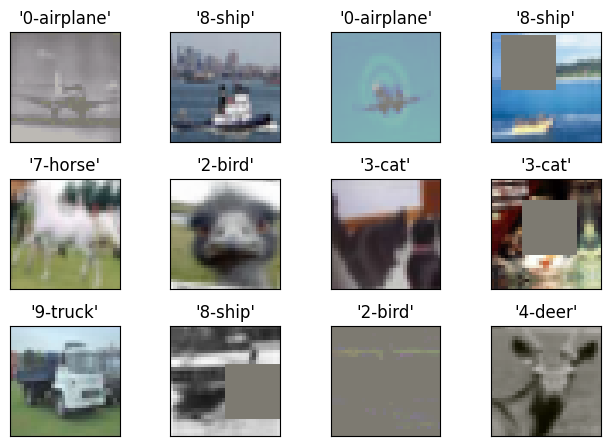

In [14]:
cifar10_data.show_dataset_images()

## Instantiate Model

In [15]:
model1 = Net(dropout=0.05, skip=True)

In [16]:
model1.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Param %
Net                                      [512, 3, 32, 32]          [512, 10]                 --                        --                             --
├─Sequential: 1-1                        [512, 3, 32, 32]          [512, 23, 32, 32]         --                        --                             --
│    └─convLayer: 2-1                    [512, 3, 32, 32]          [512, 23, 32, 32]         --                        --                             --
│    │    └─Sequential: 3-1              [512, 3, 32, 32]          [512, 23, 32, 32]         621                       --                          0.33%
│    │    └─BatchNorm2d: 3-2             [512, 23, 32, 32]         [512, 23, 32, 32]         46                        --                          0.02%
│    │    └─ReLU: 3-3                    [512, 23, 32, 32]         [512, 23, 32, 3

## Train Model

In [17]:
EPOCHS = 100

optimizer = get_sgd_optimizer(model1)
scheduler = get_one_cycle_LR_scheduler(optimizer,
                                       cifar10_data.train_loader,
                                       EPOCHS)

In [18]:
train_model1 = trainModel(model1, optimizer, scheduler,
                          train, test, cifar10_data.train_loader,
                          cifar10_data.test_loader, lr=0.05, epochs=EPOCHS,
                          device=device)

train_model1.run_training_model()

| Epoch | LR       | Time    | TrainLoss | TrainAcc | TestLoss | TestAcc |
|     1 | 0.005000 | 00m 29s | 1.867076  |  23.28%  | 1.648807 |  38.79% |
|     2 | 0.005147 | 00m 29s | 1.586370  |  39.09%  | 1.391627 |   49.7% |
|     3 | 0.005585 | 00m 31s | 1.339016  |  46.08%  | 1.261456 |  54.61% |
|     4 | 0.006313 | 00m 29s | 1.368494  |  50.15%  | 1.173368 |  58.14% |
|     5 | 0.007326 | 00m 28s | 1.129130  |  53.52%  | 1.103729 |  60.62% |
|     6 | 0.008618 | 00m 29s | 1.112360  |  56.67%  | 1.001634 |  63.78% |
|     7 | 0.010180 | 00m 29s | 1.145815  |  59.16%  | 0.926470 |  67.06% |
|     8 | 0.012003 | 00m 31s | 1.132433  |  61.28%  | 0.959502 |  66.13% |
|     9 | 0.014076 | 00m 29s | 1.041838  |  63.05%  | 0.849625 |  70.04% |
|    10 | 0.016386 | 00m 29s | 0.954699  |  64.61%  | 0.953913 |  67.31% |
|    11 | 0.018919 | 00m 29s | 0.895106  |  65.94%  | 0.778798 |  73.12% |
|    12 | 0.021659 | 00m 30s | 0.888296  |  66.91%  | 0.772291 |  73.32% |
|    13 | 0.024589 | 00m 

## Plot Model Statistics

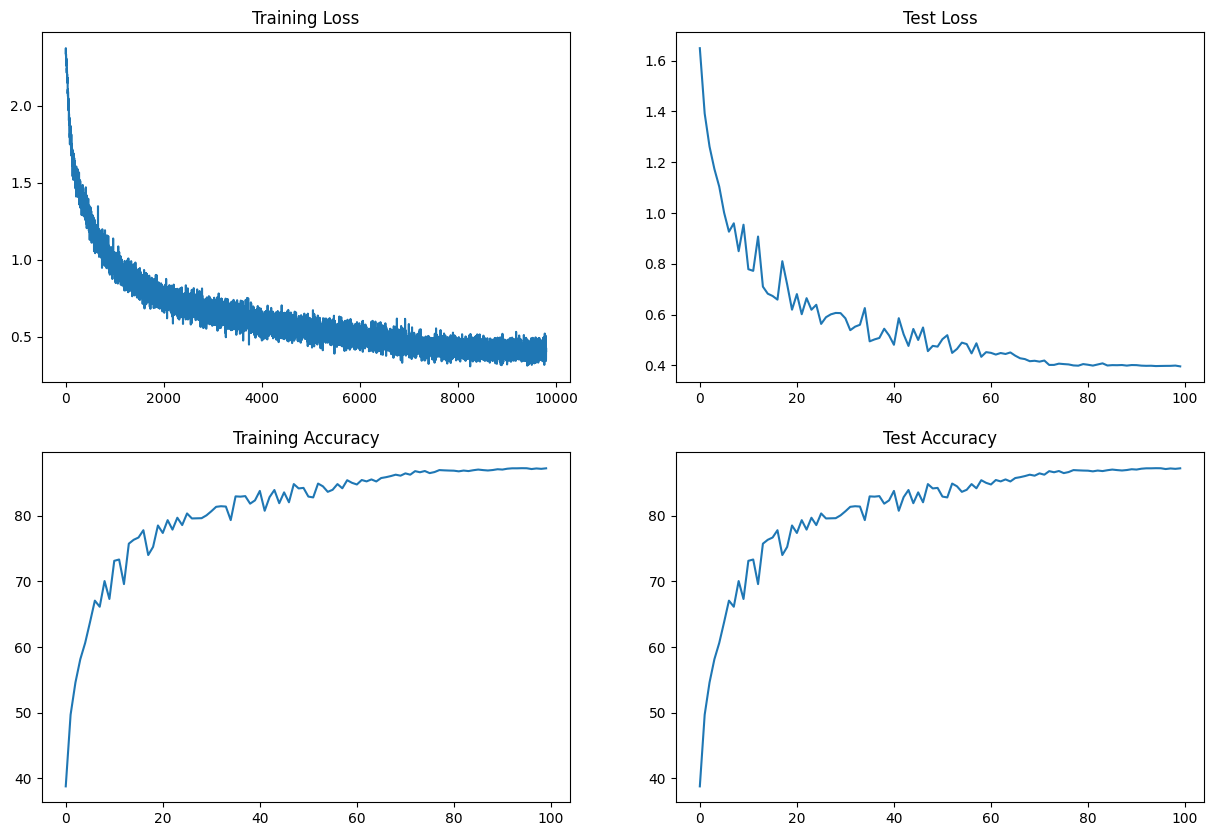

In [19]:
train_model1.display_model_stats()

In [24]:
train_model1.show_best_model()

Test Accuracy: 87.22% | Test Loss: 0.397522


## Display Incorrect Predictions

In [22]:
model1_incorrect_pred = get_incorrect_test_predictions(model1,
                                                    device,
                                                    cifar10_data.test_loader)

0 - 'airplane' 1 - 'automobile' 2 - 'bird' 3 - 'cat' 4 - 'deer' 5 - 'dog' 6 - 'frog' 7 - 'horse' 8 - 'ship' 9 - 'truck' 

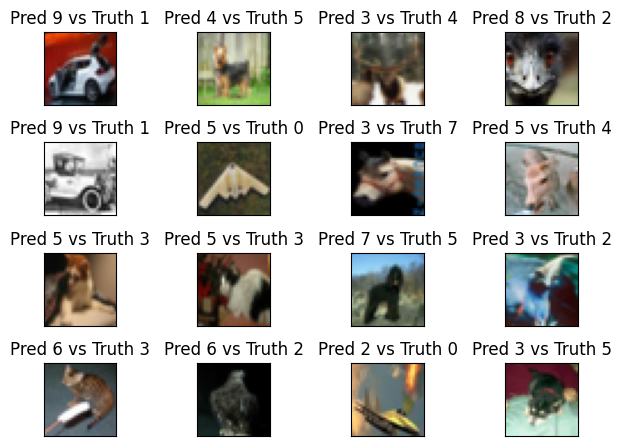

In [23]:
cifar10_data.show_cifar10_incorrect_predictions(denormalize=True,
                                                incorrect_prediction=model1_incorrect_pred)

## Observations & Insights

#### Code Block - Final Optimal Model


**Target:**

- Network Architecture - Dilated Convolution + Depthwise Separable Convolution
- Layer Structure - C1 C2 C3 C4 Output + No MaxPooling, all convolution blocks
have 3 layers and use 3x3 convolutions, GAP + FC + 1x1 convolutions
- Image Augmentation using Albumentation Transforms - Color Jitter + To Gray +
Horizontal flip + Shift Scale Rotate + Coarse Dropout
- Skip connections used
- Batch Normalization used
- Dropout of 0.05 and one cycle learning rate with max LR as 0.1 used
- L1 regularization degraded the performance and led the model to over-fitting,
hence it is not used
- The receptive field we got with this network architecture is 48

**Results:**

- Parameters: 190.509K
- Best Train Accuracy: 86.19%
- Best Test Accuracy: 87.22% (95th Epoch)
- Test Accuracy: 85.39% (59th Epoch) [First occurrence of test accuracy above 85%]

**Analysis:**
- Model has no over fitting through out the training
- Scheduling OneCycle LR with pct_start = 0.4 gave better train/test accuracies
trend in the first 100 epochs
  - Keeping the LR fixed at 0.1 did not show this kind of performance, the best
  test accuracy achieved with in first 100 epochs is only 86.83%